In [1]:
import os, sys
import random, h5py
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import SGD

#Initialize the Program
alphabet = "NACGT."
vocab_size = 6
batch_size = 1000
embedding_size = 5
time_steps = 101
category = 2

char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))


Using TensorFlow backend.


In [2]:
def reverse_complement(sequence):
    retseq = ''
    for k in range(len(sequence)-1, -1, -1):
        if sequence[k] == 'A':
            retseq = retseq + 'T'
        elif sequence[k] == 'T':
            retseq = retseq + 'A'
        elif sequence[k] == 'C':
            retseq = retseq + 'G'
        elif sequence[k] == 'G':
            retseq = retseq + 'C'
        else:
            retseq = retseq + sequence[k]

    """
    print("Revese:")
    print(sequence)
    print(retseq)
    print()
    """
    return retseq


In [3]:
file_read = open("../imgtvgene_sequence_classification/mem.txt")

given_sequence = []
given_cdr3 = []

source_sequence = []
target_sequence = []

cluster_tag = []
cluster_dic = {}
classes = 0

vgene_tag = []
vgene_dic = {}
vgenes = 0

count = 0
max_count = 100000

max_source = 0
max_target = 0

line = file_read.readline()
for line in file_read:
    split = line.strip().split(" ")
    #print(split)
    
    given_sequence.append(split[2][1:-1])
    given_cdr3.append(split[-2][1:-1])
    
    if not split[1] in cluster_dic:
        classes += 1
        cluster_dic[split[1]] = classes
    cluster_tag.append(split[1])
    
    source = [char_to_int[x] for x in split[2][1:-1]]
    source_sequence.append(source)
    if max_source < len(source):
        max_source = len(source)
    
    target = [char_to_int[x] for x in split[-2][1:-1]]
    target_sequence.append(target)
    if max_target < len(target):
        max_target = len(target)
    
    vgene_name = split[-1][1:-1].split("-")[0]
    if not vgene_name in vgene_dic:
        vgene_dic[vgene_name] = vgenes
        vgenes += 1
    vgene_tag.append(vgene_dic[vgene_name])
    
    count += 1
    
    #print(split[1], vgene_name)
    if count == max_count:
        break
    
source_sequence = np.array(source_sequence)
target_sequence = np.array(target_sequence)

cluster_tag = np.array(cluster_tag)
vgene_tag = np.array(vgene_tag)

print(source_sequence.shape, target_sequence.shape)
print(max_source, max_target)
print()
print(cluster_tag.shape, vgene_tag.shape)
print(classes, vgenes)


(100000,) (100000,)
526 201

(100000,) (100000,)
73112 7


# CDR3 Region Identifcation

In [4]:
x_data = []
y_data = []
seq_length = 20
for k in range(max_count):
    st_ind = given_sequence[k].find(given_cdr3[k])
    for i in range(st_ind, st_ind+len(given_cdr3[k])):
    
        #random_ind = np.random.randint(low=0, high=st_ind-10, size=None)
        #while True:
        random_ind = np.random.randint(low=0, \
                                       high=len(given_sequence[k]), \
                                       size=None)

        if not (random_ind < st_ind or \
                random_ind >= st_ind+len(given_cdr3[k])):
                continue

        x_data.append(source_sequence[k][i-seq_length:i+seq_length])
        y_data.append(1)
        
        x_data.append(source_sequence[k][random_ind:random_ind+2*seq_length])
        y_data.append(0)
    
x_data = np.array(x_data)
y_data = np.array(y_data)

In [5]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

x_data = pad_sequences(x_data, maxlen=2*seq_length, value=0)

train_index = int((len(x_data) / batch_size) * 0.60 * batch_size)
eval_index = train_index + int((len(x_data) / batch_size) * 0.20 * batch_size)
test_index = eval_index + int((len(x_data) / batch_size) * 0.20 * batch_size)
print("train, eval, test = ", (train_index, eval_index, test_index))

x_train = x_data[0:train_index]
y_train = y_data[0:train_index]

x_eval = x_data[train_index:eval_index]
y_eval = y_data[train_index:eval_index]

x_test = x_data[eval_index:test_index]
y_test = y_data[eval_index:test_index]

print(x_train.shape, y_train.shape)
print(x_eval.shape, y_eval.shape)
print(x_test.shape, y_test.shape)

train, eval, test =  (4731314, 6308418, 7885522)
(4731314, 40) (4731314,)
(1577104, 40) (1577104,)
(1577104, 40) (1577104,)


In [6]:
print(x_train[0], y_train[0])
print(x_train[1], y_train[1])

[1 2 1 2 1 3 2 2 1 2 1 4 1 4 4 1 2 4 3 4 3 2 1 4 3 3 3 3 3 4 2 4 3 4 2 2 2
 1 3 4] 1
[1 2 1 4 4 4 4 4 4 2 3 1 1 4 3 1 2 3 1 3 1 1 1 4 2 2 4 1 2 1 3 2 1 2 1 4 2
 4 2 4] 0


In [7]:
from keras.layers import Input, Embedding
from keras.layers import Reshape, Dense
from keras.models import Model

input_source = Input(shape=(2*seq_length,), \
                     dtype='int32', name='main_input')
embedding = Embedding(input_dim=vocab_size, \
                      output_dim=embedding_size, \
                      input_length=2*seq_length, \
                      name='embedding')(input_source)

reshape_layer = Reshape((2*seq_length*embedding_size,))(embedding)

dense_layer_first = Dense(64, activation='relu', \
                        name='fstlayer')(reshape_layer)
dense_layer_first = Dropout(0.25)(dense_layer_first)

dense_layer_mid = Dense(32, activation='relu', \
                        name='midlayer')(dense_layer_first)
dense_layer_mid = Dropout(0.25)(dense_layer_mid)

dense_layer = Dense(16, activation='relu', \
                    name='finlayer')(dense_layer_mid)
dense_layer = Dropout(0.25)(dense_layer)

dense_output = Dense(1, activation='sigmoid', \
                     name='output')(dense_layer)#reshape_layer

model = Model(inputs=[input_source], outputs=[dense_output])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 40)                0         
_________________________________________________________________
embedding (Embedding)        (None, 40, 5)             30        
_________________________________________________________________
reshape_1 (Reshape)          (None, 200)               0         
_________________________________________________________________
fstlayer (Dense)             (None, 64)                12864     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
midlayer (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
__________

In [8]:
from keras_tqdm import TQDMNotebookCallback
print('Train...')

history = model.fit(x_train, y_train, \
          validation_data=(x_eval, y_eval), \
          epochs=20, shuffle=True, batch_size=1000, \
           callbacks=[TQDMNotebookCallback()], verbose=2)
score = model.evaluate(x_test, y_test, \
                       batch_size=1000, verbose=2)
print(score)

Train...
Train on 4731314 samples, validate on 1577104 samples
Epoch 1/20
 - 52s - loss: 0.2246 - acc: 0.9182 - val_loss: 0.1515 - val_acc: 0.9485
Epoch 2/20
 - 54s - loss: 0.1818 - acc: 0.9376 - val_loss: 0.1462 - val_acc: 0.9506
Epoch 3/20
 - 53s - loss: 0.1773 - acc: 0.9393 - val_loss: 0.1441 - val_acc: 0.9515
Epoch 4/20
 - 54s - loss: 0.1754 - acc: 0.9400 - val_loss: 0.1431 - val_acc: 0.9518
Epoch 5/20
 - 53s - loss: 0.1737 - acc: 0.9406 - val_loss: 0.1432 - val_acc: 0.9517
Epoch 6/20
 - 54s - loss: 0.1730 - acc: 0.9409 - val_loss: 0.1426 - val_acc: 0.9517
Epoch 7/20
 - 55s - loss: 0.1724 - acc: 0.9410 - val_loss: 0.1411 - val_acc: 0.9528
Epoch 8/20
 - 55s - loss: 0.1719 - acc: 0.9413 - val_loss: 0.1411 - val_acc: 0.9527
Epoch 9/20
 - 55s - loss: 0.1715 - acc: 0.9414 - val_loss: 0.1412 - val_acc: 0.9525
Epoch 10/20
 - 54s - loss: 0.1712 - acc: 0.9414 - val_loss: 0.1407 - val_acc: 0.9526
Epoch 11/20
 - 55s - loss: 0.1711 - acc: 0.9416 - val_loss: 0.1409 - val_acc: 0.9527
Epoch 12/20

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


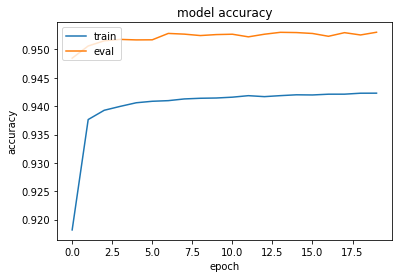

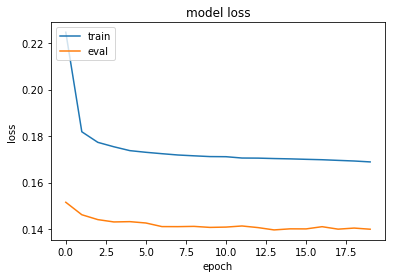

In [9]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()

In [10]:
from sklearn.metrics import confusion_matrix, classification_report

y_predict = model.predict(x_data)
print(classification_report(y_true=y_data, y_pred=np.round(y_predict)))
result = [int(y_predict[i] >= 0.50) for i in range(len(y_predict))]
#print(len(result), len(y_test))
print("Accuracy: ", (1.0 * np.sum(np.equal(result, y_data)) / len(y_data)))

             precision    recall  f1-score   support

          0       0.98      0.93      0.95   3942762
          1       0.93      0.98      0.96   3942762

avg / total       0.96      0.95      0.95   7885524

Accuracy:  0.9543644785051697


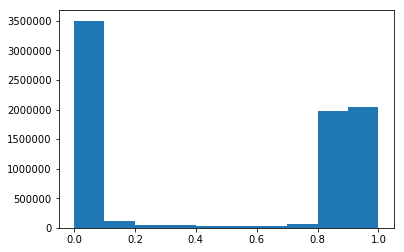

In [11]:
import matplotlib.pyplot as plt
plt.hist(y_predict)
plt.show()